In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from DPMoSt import DPMoSt # type: ignore
from utility import data_creation, plot_data, plot_solution # type: ignore

In [2]:
device = 'cpu' #torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device used: {device}')

Device used: cpu


# Data Creation

In [3]:
n_features=2
n_subjects=50
n_time_for_subject=5
time_shifted=True

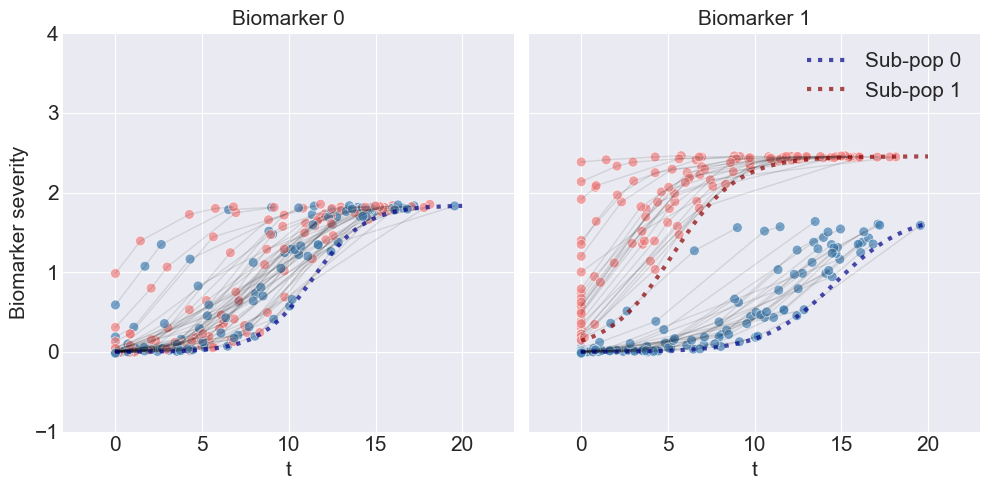

In [4]:
torch.manual_seed(2)
dict_data=data_creation(n_subjects=n_subjects, 
                        n_time_points=n_time_for_subject, 
                        n_features=n_features, 
                        noise_std=0.009, 
                        max_dist=90, 
                        min_dist=40,
                        save=False,
                        time_shifted=time_shifted, 
                        device=device)

plot_data(dict_data['data'], figsize=[10,5], dict_data=dict_data, save=False)

# DP-MoSt

In [5]:
dpmost=DPMoSt(data=dict_data['data'], 
              benchmarks=False,
              device=device, 
              time_shift_eval=time_shifted, 
              noise_std_eval=True,
              theta_eval=True, 
              pi_eval=True, 
              xi_eval=True,
              verbose=True, 
              n_prints=1)

if not dpmost.theta_eval:
    dpmost.theta[f'{dpmost.name_biomarkers[0]}_{0}_split']=dict_data[f'Biomarker_{0}']
    dpmost.theta[f'{dpmost.name_biomarkers[1]}_{1}_split']=dict_data[f'Biomarker_{1}']

if not dpmost.xi_eval: dpmost.xi=torch.tensor(dict_data['xi_true'], device=device)
if not dpmost.pi_eval: dpmost.pi=torch.tensor(dict_data['pi_true'], device=device)

if not dpmost.noise_std_eval: dpmost.log_noise_std=torch.log(dict_data['noise_std']).to(device)

Initialisation:
    Num samples: 250
    Num subjects: 50
    Num features: 2
    Evaluation time-shift: True
    Lambda regression xi: 5.0
    Lambda regression noise: 7.5
    Lambda regression theta: 0.001



In [6]:
dpmost.optimise(n_outer_iterations=10, 
                n_final_iterations=20, 
                n_inner_iterations_time_shift=20, 
                n_inner_iterations_theta=20,
                n_inner_iterations_noise=20, 
                lr_theta=1e-1, 
                lr_noise=1e-2, 
                lr_time_shift=1e-2,
                stopping_criteria=False)

iter 1/10 -- loss: 29.1035
    P(split Biomarker_0) = 0.4392     P(split Biomarker_1) = 0.3842 
    noisestd Biomarker_0 = 0.6246     noisestd Biomarker_1 = 0.7942 

iter 2/10 -- loss: 24.3685
    P(split Biomarker_0) = 0.4116     P(split Biomarker_1) = 0.3561 
    noisestd Biomarker_0 = 0.5180     noisestd Biomarker_1 = 0.7109 

iter 3/10 -- loss: 20.9039
    P(split Biomarker_0) = 0.3863     P(split Biomarker_1) = 0.3319 
    noisestd Biomarker_0 = 0.4386     noisestd Biomarker_1 = 0.6909 

iter 4/10 -- loss: 18.0656
    P(split Biomarker_0) = 0.3617     P(split Biomarker_1) = 0.3089 
    noisestd Biomarker_0 = 0.3819     noisestd Biomarker_1 = 0.6659 

iter 5/10 -- loss: 15.3401
    P(split Biomarker_0) = 0.3379     P(split Biomarker_1) = 0.2894 
    noisestd Biomarker_0 = 0.3429     noisestd Biomarker_1 = 0.6162 

iter 6/10 -- loss: 11.9300
    P(split Biomarker_0) = 0.3149     P(split Biomarker_1) = 0.2809 
    noisestd Biomarker_0 = 0.3170     noisestd Biomarker_1 = 0.5499 

iter

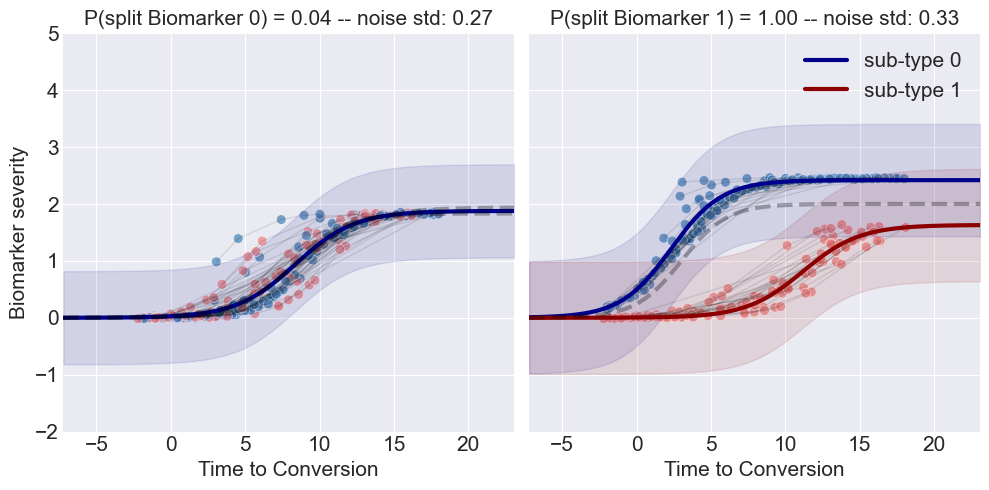

In [10]:
plot_solution(dpmost, x_lim=[dpmost.est_time.min()-5, dpmost.est_time.max()+5], show=True, save=False)

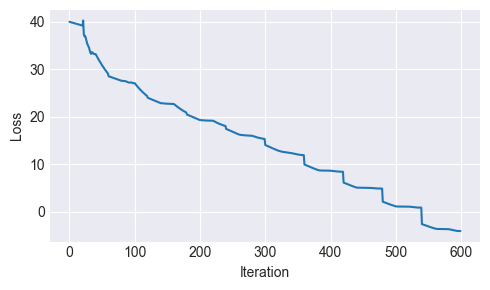

In [8]:
plt.figure(figsize=(5,3))
plt.plot(dpmost.all_loss)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()